## Heart failure clinical records Data Set
[Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data) <br>
[UCI](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

spark = (SparkSession
    .builder
    .appName("Cardiovascular Disease")
    .getOrCreate())

file="datasets/Heart_Failure_Prediction/heart_failure_clinical_records_dataset.csv"

In [2]:
from pyspark.sql.types import *
schema = StructType([StructField("age", DoubleType(), False),
                     StructField("anaemia", IntegerType(), False),
                     StructField("creatinine_ph", DoubleType(), False),
                     StructField("diabetes", IntegerType(), False),
                     StructField("ejection_fraction", DoubleType(), False),
                     StructField("h_blood_pressure", IntegerType(), False),
                     StructField("platelets", DoubleType(), False),
                     StructField("serum_creatinine", DoubleType(), False),
                     StructField("serum_sodium", DoubleType(), False),
                     StructField("sex", IntegerType(), False),     #female 0, male 1
                     StructField("smoking", IntegerType(), False),
                     StructField("time", DoubleType(), False),
                     StructField("DEATH_EVENT", IntegerType(), False),
                    ])
df=spark.read.csv(file, header=True, schema=schema)#.drop('time')

In [3]:
df.show(10)
df.describe().show()
df.groupBy('sex','DEATH_EVENT').count().show()

+----+-------+-------------+--------+-----------------+----------------+---------+----------------+------------+---+-------+----+-----------+
| age|anaemia|creatinine_ph|diabetes|ejection_fraction|h_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+-------------+--------+-----------------+----------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|      0|        582.0|       0|             20.0|               1| 265000.0|             1.9|       130.0|  1|      0| 4.0|          1|
|55.0|      0|       7861.0|       0|             38.0|               0|263358.03|             1.1|       136.0|  1|      0| 6.0|          1|
|65.0|      0|        146.0|       0|             20.0|               0| 162000.0|             1.3|       129.0|  1|      1| 7.0|          1|
|50.0|      1|        111.0|       0|             20.0|               0| 210000.0|             1.9|       137.0|  1|      0| 7.0|          1|
|65.0|

serum_creatinine normal range 0.84 to 1.2 (6 è altissimo, qua ci sono alcuni 9)<br>
serum_sodium normal range 135 to 145 (Hyponatremia <135 for Heart, kidney and liver problems)<br>
ejection_fraction normal range 55% to 70% (ci sono dei 14 troooppo bassi)<br>
creatinine phosphokinase normal range 10 to 120__altra fonte male 39 – 308, female 26 – 192 (valori altissimi 7861)<br>

## Outliers
tentativo di togliere gli outliers ma peggiora solo le cose

In [5]:
df.filter(F.col('creatinine_ph')>4000).show()

+----+-------+-------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+-----+-----+
| age|anaemia|creatinine_ph|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking| time|label|
+----+-------+-------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+-----+-----+
|55.0|    0.0|       7861.0|     0.0|             38.0|                0.0|263358.03|             1.1|       136.0|1.0|    0.0|  6.0|  1.0|
|45.0|    0.0|       7702.0|     1.0|             25.0|                1.0| 390000.0|             1.0|       139.0|1.0|    0.0| 60.0|  1.0|
|85.0|    0.0|       5882.0|     0.0|             35.0|                0.0| 243000.0|             1.0|       132.0|1.0|    1.0| 72.0|  1.0|
|42.0|    0.0|       5209.0|     0.0|             30.0|                0.0| 226000.0|             1.0|       140.0|1.0|    1.0| 87.0|  0.0|
|81.0|    0.0|      

In [7]:
df.filter(F.col('serum_creatinine')>6).show()

+----+-------+-------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+-----+-----+
| age|anaemia|creatinine_ph|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking| time|label|
+----+-------+-------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+-----+-----+
|80.0|    1.0|        123.0|     0.0|             35.0|                1.0| 388000.0|             9.4|       133.0|1.0|    1.0| 10.0|  1.0|
|60.0|    0.0|       3964.0|     1.0|             62.0|                0.0|263358.03|             6.8|       146.0|0.0|    0.0| 43.0|  1.0|
|60.0|    1.0|       1082.0|     1.0|             45.0|                0.0| 250000.0|             6.1|       131.0|1.0|    0.0|107.0|  0.0|
|54.0|    1.0|        427.0|     0.0|             70.0|                1.0| 151000.0|             9.0|       137.0|0.0|    0.0|196.0|  1.0|
+----+-------+------

In [13]:
df1=df.filter((df.serum_creatinine<6) & (df.creatinine_ph<4000))
df1.describe().show()

+-------+------------------+-------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+-------------------+
|summary|               age|            anaemia|    creatinine_ph|          diabetes| ejection_fraction|high_blood_pressure|        platelets|  serum_creatinine|     serum_sodium|               sex|            smoking|              time|              label|
+-------+------------------+-------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+------------------+-------------------+------------------+-------------------+
|  count|               290|                290|              290|               290|               290|                290|              290|               290|              290|               290|                290|        

## Analisi Esplorativa
[vedi documentazione plotly boxplot](https://plotly.com/python/box-plots/)

In [4]:
df5=df
i='sex'
df5=df5.withColumn(i+'_', F.when(F.col(i) == 1, 'Male')
                           .when(F.col(i) == 0,"Female")
                           ).drop(i)

df5=df5.withColumnRenamed(i+'_',i.replace(" ",'_'))
i='DEATH_EVENT'
df5=df5.withColumn(i+'_', F.when(F.col(i) == 1, 'Deceased')
                           .when(F.col(i) == 0,"Not deceased")
                           ).drop(i)
df5=df5.withColumnRenamed(i+'_',i.replace(" ",'_'))

df5.groupBy('sex').count().show(5)

+------+-----+
|   sex|count|
+------+-----+
|Female|  105|
|  Male|  194|
+------+-----+



In [5]:
pdf=df5.toPandas()
fig = px.box(pdf, x='sex', y='age', points="all", color='DEATH_EVENT', width=800, height=600, color_discrete_sequence=['#F04B50','#2C85C1'])
fig.update_layout(legend=dict(
    title='Death event:',
    yanchor="top",
    y=0.98,
    xanchor="right",
    x=0.98
))

fig.show()

## Separate Categorical from Numerical columns

In [6]:
categorical = [field for (field, dataType) in df.dtypes if (dataType=='int') and (field!='DEATH_EVENT')]
numerical = [field for (field, dataType) in df.dtypes if dataType=='double']
print(categorical)
print(numerical)

['anaemia', 'diabetes', 'h_blood_pressure', 'sex', 'smoking']
['age', 'creatinine_ph', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


# Correlation
[source from correlation to list of lists todataframe to (bad)heatmap](https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks)

In [8]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

correlationCols = numerical+['DEATH_EVENT']

df2 = VectorAssembler(inputCols=correlationCols, 
                               outputCol="features").transform(df)

matrix=Correlation.corr(df2,'features').collect()[0][0]
corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)
print()
dfc = spark.createDataFrame(corrmatrix,correlationCols)
dfc.show()


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 age|       creatinine_ph|   ejection_fraction|           platelets|    serum_creatinine|        serum_sodium|                time|         DEATH_EVENT|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.08158389977909215|0.060098363232912705|-0.05235436663012695|    0.15918713328355|-0.04596584083955...|-0.22406841997203492| 0.25372854308800324|
|-0.08158389977909215|                 1.0|-0.04407955445671145| 0.02446338851957413|-0.01640847954621...| 0.05955015583372568|-0.00934565314298...| 0.06272816025237468|
|0.060098363232912705|-0.04407955445671145|                 1.0| 0.07217746574434995|-0.01130247499541...| 0.17590228200796226|0.041729235483529935| 

<ipython-input-9-1811d673767c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-9-1811d673767c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


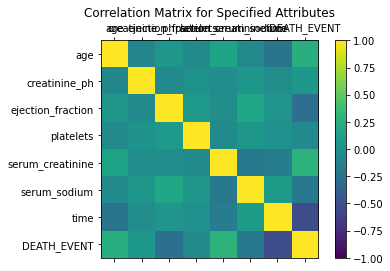

In [9]:
import matplotlib.pyplot as plt
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, correlationCols, 234)

<AxesSubplot:>

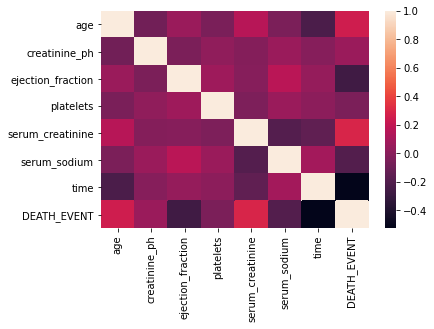

In [10]:
#import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

# load the R package ISLR
#infert = com.importr("ISLR")

# load the Auto dataset
auto_df = df.select(correlationCols).toPandas()

# calculate the correlation matrix
corr = auto_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

[source of heat map](https://stackoverflow.com/questions/39409866/correlation-heatmap)

In [11]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## Mutual Information (Pandas)
https://www.kaggle.com/ryanholbrook/mutual-information

In [12]:
pdf = df.toPandas()
X = df.toPandas()
y = X.pop('DEATH_EVENT')
discrete_features = [i for i in df.columns if (i!='label')]
X.head()

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(["C0"] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index)
           if col.startswith("PROBE")]
    color[idx] = "C3"
    # Create plot
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [13]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y)#, discrete_features=[1,1,1,1,1,1,1,1,1,1,1,1,1])
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

time                 0.247272
serum_creatinine     0.065628
anaemia              0.046137
ejection_fraction    0.045263
creatinine_ph        0.037256
smoking              0.035644
age                  0.027565
sex                  0.022831
diabetes             0.000000
h_blood_pressure     0.000000
platelets            0.000000
serum_sodium         0.000000
Name: MI Scores, dtype: float64

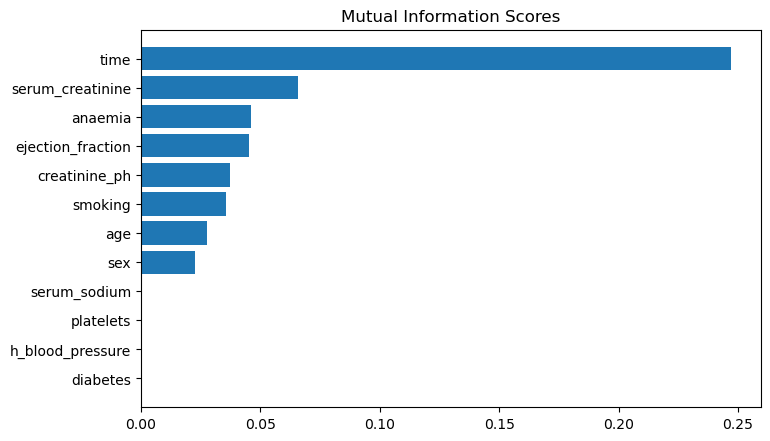

In [16]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

# Preparazione features

## ALBERI gestiscono le features categoriche
visto che le features erano state indicizzate manualmente serve solo il VectorAssembler

In [7]:
from pyspark.ml.feature import VectorAssembler

MIsubset1 = ['time', 'serum_creatinine',  'ejection_fraction','anaemia', 'creatinine_ph', 'smoking', 'age', 'sex']
MIsubset2 = ['time', 'serum_creatinine',  'ejection_fraction']#,'anaemia', 'creatinine_ph', 'smoking', 'age', 'sex']

assemblerInputsTree = categorical + numerical

df_tree=(VectorAssembler(inputCols=assemblerInputsTree,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                                        ).select('label','features')

df_tree_cat=(VectorAssembler(inputCols=categorical,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                                        ).select('label','features')
df_tree_num=(VectorAssembler(inputCols=numerical,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                                        ).select('label','features')

df_tree_sub2=(VectorAssembler(inputCols=MIsubset1,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                                        ).select('label','features')

df_tree_sub1=(VectorAssembler(inputCols=MIsubset2,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                                        ).select('label','features')
df_tree.show(5,truncate=False)

+-----+--------------------------------------------------------------+
|label|features                                                      |
+-----+--------------------------------------------------------------+
|1    |[0.0,0.0,1.0,1.0,0.0,75.0,582.0,20.0,265000.0,1.9,130.0,4.0]  |
|1    |[0.0,0.0,0.0,1.0,0.0,55.0,7861.0,38.0,263358.03,1.1,136.0,6.0]|
|1    |[0.0,0.0,0.0,1.0,1.0,65.0,146.0,20.0,162000.0,1.3,129.0,7.0]  |
|1    |[1.0,0.0,0.0,1.0,0.0,50.0,111.0,20.0,210000.0,1.9,137.0,7.0]  |
|1    |[1.0,1.0,0.0,0.0,0.0,65.0,160.0,20.0,327000.0,2.7,116.0,8.0]  |
+-----+--------------------------------------------------------------+
only showing top 5 rows



## TREE features selection with PCA Only
lategoriche per intero e le numeriche tramite pca

In [72]:
def get_tree_PCA(k,df=df):
    from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline

    vecNum2 = VectorAssembler(inputCols=categorical, outputCol='numFeatures')

    scaler2 = StandardScaler(inputCol="numFeatures", outputCol="scaledFeatures",
                            withStd=True, withMean=False)

    pca2 = PCA(k=k, inputCol="scaledFeatures", outputCol="pcaFeatures")

    vecAss2 = VectorAssembler(inputCols=categorical+["pcaFeatures"], outputCol='features')

    pipeline = Pipeline(stages=[vecNum2,scaler2,pca2,vecAss2])
    return pipeline.fit(df).transform(df).withColumnRenamed('DEATH_EVENT','label').select('label','features')

get_tree_PCA(5).show(5,truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                    |
+-----+----------------------------------------------------------------------------------------------------------------------------+
|1    |[0.0,0.0,1.0,1.0,0.0,0.9575934413336427,1.2590696182988335,-1.4336125033486515,-1.1918962075575967,-1.6644075650777173]     |
|1    |[0.0,0.0,0.0,1.0,0.0,1.3409324208000222,0.035549350363651505,0.09289587612160638,-0.583418395692713,-1.4919140493423535]    |
|1    |[0.0,0.0,0.0,1.0,1.0,2.691991318489679,0.1396441459353839,-0.04716552179636682,-1.295280925865176,-0.005446547615059583]    |
|1    |[1.0,0.0,0.0,1.0,0.0,0.8861351377224697,1.1553349273329607,1.448039195751201,-1.45743338583584,-1.4478371956024243]         |
|1    |[1.0,1.0,0.0,0.0,0.0,-1.1112499324684926,-0.07161470377302726,

## OneHotEncoding Features

In [77]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
oheInputs = categorical
oheOutput = [x+'_ohe' for x in oheInputs]

assemblerInputsOHE = numerical+oheOutput


OHE_df = OneHotEncoder(inputCols=oheInputs, 
                           outputCols=oheOutput).fit(df).transform(df)

df_ohe=(VectorAssembler(inputCols=assemblerInputsOHE,
                        outputCol='features')
                        .transform(OHE_df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                          ).select('label','features')
df_ohe.show(5,truncate=False)

#SUBSETS
MIsubset1 = ['time', 'serum_creatinine',  'ejection_fraction','anaemia', 'creatinine_ph', 'smoking', 'age', 'sex']
MIsubset2 = ['time', 'serum_creatinine',  'ejection_fraction']
# ['anaemia', 'diabetes', 'h_blood_pressure', 'sex', 'smoking']
# ['age', 'creatinine_ph', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

df_sub2 = df_tree_sub2

MIsub1cat = ['anaemia', 'sex', 'smoking']
MIsub1num = ['time', 'serum_creatinine',  'ejection_fraction', 'creatinine_ph', 'age']

oheInputs2 = MIsub1cat
oheOutput2 = [x+'_ohe' for x in oheInputs2]

assemblerInputsOHE2 = MIsub1num+oheOutput2

OHE_df = OneHotEncoder(inputCols=oheInputs2, 
                           outputCols=oheOutput2).fit(df).transform(df)
df_sub1=(VectorAssembler(inputCols=assemblerInputsOHE2,
                        outputCol='features')
                        .transform(OHE_df)
                        .withColumnRenamed('DEATH_EVENT','label')
                                          ).select('label','features')
df_sub1.show(5,truncate=False)


+-----+--------------------------------------------------------------+
|label|features                                                      |
+-----+--------------------------------------------------------------+
|1    |[75.0,582.0,20.0,265000.0,1.9,130.0,4.0,1.0,1.0,0.0,0.0,1.0]  |
|1    |[55.0,7861.0,38.0,263358.03,1.1,136.0,6.0,1.0,1.0,1.0,0.0,1.0]|
|1    |[65.0,146.0,20.0,162000.0,1.3,129.0,7.0,1.0,1.0,1.0,0.0,0.0]  |
|1    |[50.0,111.0,20.0,210000.0,1.9,137.0,7.0,0.0,1.0,1.0,0.0,1.0]  |
|1    |[65.0,160.0,20.0,327000.0,2.7,116.0,8.0,0.0,0.0,1.0,1.0,1.0]  |
+-----+--------------------------------------------------------------+
only showing top 5 rows

+-----+--------------------------------------+
|label|features                              |
+-----+--------------------------------------+
|1    |[4.0,1.9,20.0,582.0,75.0,1.0,0.0,1.0] |
|1    |[6.0,1.1,38.0,7861.0,55.0,1.0,0.0,1.0]|
|1    |[7.0,1.3,20.0,146.0,65.0,1.0,0.0,0.0] |
|1    |[7.0,1.9,20.0,111.0,50.0,0.0,0.0,1.0] |
|1    |

### OHE con PCA

In [53]:
def getOHE_PCAdf(k, df=df):

    from pyspark.ml.feature import OneHotEncoder, PCA, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline

    #CATEGORICAL
    oheInputs = categorical
    oheOutput = [x+'_ohe' for x in oheInputs]

    ohe1 = OneHotEncoder(inputCols=oheInputs, 
                               outputCols=oheOutput)#.fit(df).transform(df)

    #NUMERICAL
    vecNum1 = VectorAssembler(inputCols=numerical, outputCol='numFeatures')

    scaler1 = StandardScaler(inputCol="numFeatures", outputCol="scaledFeatures",
                            withStd=True, withMean=False)

    pca1 = PCA(k=k, inputCol="scaledFeatures", outputCol="pcaFeatures")


    #REUNITE CATEGORICAL AND NUMERICAL
    assemblerInputs=oheOutput+["pcaFeatures"]

    vecAss1 = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
    #                         .transform(OHE_df)
    #                         .withColumnRenamed('Class','label')
    #                                                             ).select('label','features')

    pipeline = Pipeline(stages=[ohe1,vecNum1,scaler1,pca1,vecAss1])

    return (pipeline.fit(df).transform(df).withColumnRenamed('DEATH_EVENT','label')
                                                .select('label','features'))
    
df_ohe_pca = createOHE_PCAdf(4,df)
df_ohe_pca.show(5,truncate=False)

+-----+-------------------------------------------------------------------------------------------------+
|label|features                                                                                         |
+-----+-------------------------------------------------------------------------------------------------+
|1    |[1.0,1.0,0.0,0.0,1.0,10.259648483754392,17.28807170431324,4.995592137822613,9.590359321808258]   |
|1    |[1.0,1.0,1.0,0.0,1.0,13.361661302236032,16.649089578647487,11.026328188981061,12.430935692963068]|
|1    |[1.0,1.0,1.0,0.0,0.0,10.592710661687397,16.603019129798845,4.111132289890516,10.15777325402633]  |
|1    |[0.0,1.0,1.0,0.0,1.0,11.78621818933606,16.966569096726897,4.562370188619283,10.044710944370102]  |
|1    |[0.0,0.0,1.0,1.0,1.0,8.926305616299631,15.809604713495986,4.5885446423888405,7.461351260458357]  |
+-----+-------------------------------------------------------------------------------------------------+
only showing top 5 rows



### SCALER PCA MinMaxScaler solo per NaiveBayes
Il NaiveBayer da un errore con features negative, il MinMax le porta in un range [0,1]

In [75]:
def getOHE_PCA_mM_df(k, df=df):
    from pyspark.ml.feature import OneHotEncoder, PCA, VectorAssembler, StandardScaler, MinMaxScaler
    from pyspark.ml import Pipeline

    #CATEGORICAL
    oheInputs = categorical
    oheOutput = [x+'_ohe' for x in oheInputs]

    ohe1 = OneHotEncoder(inputCols=oheInputs, 
                               outputCols=oheOutput)#.fit(df).transform(df)

    #NUMERICAL
    vecNum1 = VectorAssembler(inputCols=numerical, outputCol='numFeatures')

    scaler1 = StandardScaler(inputCol="numFeatures", outputCol="scaledFeatures",
                            withStd=True, withMean=False)

    pca1 = PCA(k=k, inputCol="scaledFeatures", outputCol="pcaFeatures")

    scaler2 = MinMaxScaler(inputCol="pcaFeatures", outputCol='scalPcaFeatures')


    #REUNITE CATEGORICAL AND NUMERICAL
    assemblerInputs=oheOutput+['scalPcaFeatures']  #["pcaFeatures"]

    vecAss1 = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
    #                         .transform(OHE_df)
    #                         .withColumnRenamed('Class','label')
    #                                                             ).select('label','features')

    pipeline = Pipeline(stages=[ohe1,vecNum1,scaler1,pca1,scaler2,vecAss1])
    return pipeline.fit(df).transform(df).withColumnRenamed('DEATH_EVENT','label').select('label','features')

# getOHE_PCA_mM_df(5).show(5,truncate=False)
# getOHE_PCA_mM_df(4).show(5,truncate=False)

## IMPORTS

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## EVALUATORS

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

bEvaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
bEvaluator2 = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")

mEvaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Decision Tree

In [85]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

DTparamGrid = (ParamGridBuilder().addGrid(dt.impurity, ['gini'])#,'entropy'])
                               .build())

In [76]:
%%time

trainDF, testDF = df_tree_num.randomSplit([.8, .2], seed=42)

cv = CrossValidator(estimator=dt,
                    evaluator=bEvaluator,
                    estimatorParamMaps=DTparamGrid,
                    numFolds=5,
                    seed=42,
                    parallelism=20)
cvModelDT=cv.fit(trainDF)

CPU times: user 147 ms, sys: 24.9 ms, total: 172 ms
Wall time: 2.71 s


In [77]:
list(zip(cvModelDT.getEstimatorParamMaps(), cvModelDT.avgMetrics))

[({Param(parent='DecisionTreeClassifier_1b5de11df5c4', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'},
  0.7407399772866305)]

In [78]:
print("Decision Tree average area under the ROC curve:", cvModelDT.avgMetrics)

Decision Tree average area under the ROC curve: [0.7407399772866305]


In [79]:
#take the best pipelineModel and extract the decisionTreeModel from the pipeline (the last element of the stages)
dt_model=cvModelDT.bestModel#.stages[-1]
featureImp=pd.DataFrame(list(zip(assemblerInputsTree,dt_model.featureImportances)),
                        columns=['feature','importance'])
featureImp.sort_values(by='importance',ascending=False)

feature  importance
6     creatinine_ph    0.609328
2  h_blood_pressure    0.181884
0           anaemia    0.069943
5               age    0.051042
1          diabetes    0.049622
4           smoking    0.021999
3               sex    0.016182

In [80]:
DTprediction=cvModelDT.transform(testDF)
#prediction.select('label', 'prediction', 'probability').show()
DTprediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|   28|
|    1|       1.0|   13|
|    0|       1.0|    3|
+-----+----------+-----+



In [81]:
areaUnderROC = bEvaluator.evaluate(DTprediction)
print("areaUnderROC = %g" % areaUnderROC)
DT_areaUnderPR = bEvaluator2.evaluate(DTprediction)
print("areaUnderPR = %g" % DT_areaUnderPR)
DT_accuracy = mEvaluator.evaluate(DTprediction)
print("accuracy = %g" % DT_accuracy)

areaUnderROC = 0.857863
areaUnderPR = 0.768243
accuracy = 0.87234


BASELINE: <br>
areaUnderROC = 0.746976 <br>
areaUnderPR = 0.599147 <br>
accuracy = 0.765957 <br>
BASELINE SUBSET ['time', 'serum_creatinine', 'anaemia', 'ejection_fraction', 'creatinine_ph', 'smoking', 'age', 'sex']<br>
areaUnderROC = 0.684476 <br>
areaUnderPR = 0.543218 <br>
accuracy = 0.723404 <br>
BASELINE SUBSET ['time', 'serum_creatinine', 'anaemia', 'ejection_fraction'] <br>
areaUnderROC = 0.732863 <br>
areaUnderPR = 0.660406 <br>
accuracy = 0.787234 <br>
CATEGORICAL ONLY <br>
areaUnderROC = 0.515121 <br>
areaUnderPR = 0.425199 <br>
accuracy = 0.659574 <br>
NUMERICAL ONLY <br>
areaUnderROC = 0.857863 <br>
areaUnderPR = 0.768243 <br>
accuracy = 0.87234 <br>

### Decision Tree Cycle

In [108]:
%%time

dt_loop_df = df_tree_sub1 # get_tree_PCA(4)
AUCavg=[]
AUPRavg=[]
ACCavg=[]
for i in range(100):
    DTtrainDF, DTtestDF = dt_loop_df.randomSplit([.8, .2], seed=i)
#     cv = CrossValidator(estimator=dt,
#                     evaluator=bEvaluator,
#                     estimatorParamMaps=DTparamGrid,
#                     numFolds=10,
#                     seed=42,
#                     parallelism=20)
    cv=dt
    cvModelDT=cv.fit(DTtrainDF)
    DTprediction=cvModelDT.transform(DTtestDF)
    AUCavg.append(bEvaluator.evaluate(DTprediction))
    AUPRavg.append(bEvaluator2.evaluate(DTprediction))
    ACCavg.append(mEvaluator.evaluate(DTprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.793591
AUPR = 0.680068
ACC = 0.827395
CPU times: user 1.56 s, sys: 387 ms, total: 1.95 s
Wall time: 1min 5s


BASELINE:<br>
AUC = 0.752108 <br>
AUPR = 0.68215 <br>
ACC = 0.801033 <br>

BASELINE x100: <br>
AUC = 0.748774 <br>
AUPR = 0.613717 <br>
ACC = 0.787267 <br>

**MI SUBSET 1:** <br>
AUC = 0.813654 <br>
AUPR = 0.743764 <br>
ACC = 0.846828 <br>

SUBSET 1 x100: <br>
AUC = 0.793591 <br>
AUPR = 0.680068 <br>
ACC = 0.827395 <br>

MI SUBSET 2: <br>
AUC = 0.77544 <br>
AUPR = 0.706326 <br>
ACC = 0.81852 <br>

CATEGORICAL ONLY:<br>
AUC = 0.514527 <br>
AUPR = 0.427145 <br>
ACC = 0.639905 <br>

NUMERICAL ONLY: <br>
AUC = 0.763335 <br>
AUPR = 0.67163 <br>
ACC = 0.801761 <br>

PCA 5: <br>
AUC = 0.499645 <br>
AUPR = 0.334011 <br>
ACC = 0.631377 <br>

PCA 4: <br>
AUC = 0.50333 <br>
AUPR = 0.351398 <br>
ACC = 0.636369 <br>

## Random Forest
[Algorithm official documentation](https://spark.apache.org/docs/3.0.1/mllib-ensembles.html#random-forests)<br>
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression.<br>
[Ensembles official documentation](https://spark.apache.org/docs/3.0.1/ml-classification-regression.html#random-forests)<br>
Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. The spark.ml implementation supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features.

In [109]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

RFparamGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [4])# [3,4,5,8])
                                 .build())


In [103]:
%%time
trainDF, testDF = df_tree.randomSplit([.8, .2], seed=42)

cv = CrossValidator(estimator=rf,
                    evaluator=bEvaluator,
                    estimatorParamMaps=RFparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelRF=cv.fit(trainDF)

CPU times: user 243 ms, sys: 58.6 ms, total: 302 ms
Wall time: 4.02 s


In [100]:
list(zip(cvModelRF.getEstimatorParamMaps(), cvModelRF.avgMetrics))

[({Param(parent='DecisionTreeClassifier_d8caed9fbc75', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
  0.7527257014552579)]

In [38]:
print("Random Forest average area under the ROC curve:", cvModelRF.avgMetrics)

Random Forest average area under the ROC curve: [0.7624627346337873, 0.728115469411909, 0.7364056076362576, 0.7037553719500313]


In [39]:
rf_model=cvModelRF.bestModel.stages[-1]
featureImp=pd.DataFrame(list(zip(vecAssembler.getInputCols(),rf_model.featureImportances)),
                        columns=['feature','importance'])
featureImp.sort_values(by='importance',ascending=False)

feature  importance
2      creatinine_ph    0.768240
3           diabetes    0.098373
1            anaemia    0.054218
4  ejection_fraction    0.051732
0                age    0.027437
5   h_blood_pressure    0.000000

In [96]:
RFprediction=cvModelRF.transform(testDF)
#prediction.select('label', 'prediction', 'probability').show()
RFprediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    9|
|    0|       0.0|   26|
|    1|       1.0|    7|
|    0|       1.0|    5|
+-----+----------+-----+



In [97]:
areaUnderROC = bEvaluator.evaluate(RFprediction)
print("areaUnderROC = %g" % areaUnderROC)
RF_areaUnderPR = bEvaluator2.evaluate(RFprediction)
print("areaUnderPR = %g" % RF_areaUnderPR)
RF_accuracy = mEvaluator.evaluate(RFprediction)
print("accuracy = %g" % RF_accuracy)

areaUnderROC = 0.638105
areaUnderPR = 0.515016
accuracy = 0.702128


### Random Forest Cycle

In [115]:
%%time
rf_loop_df = df_tree_sub1 #df_tree_sub2

rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=4)
AUCavg=[]
AUPRavg=[]
ACCavg=[]
for i in range(100):
    RFtrainDF, RFtestDF = rf_loop_df.randomSplit([.8, .2], seed=i)
#     cv = CrossValidator(estimator=rf,
#                     evaluator=bEvaluator,
#                     estimatorParamMaps=RFparamGrid,
#                     numFolds=10,
#                     seed=42,
#                     parallelism=20)
    cv=rf
    cvModelRF=cv.fit(RFtrainDF)
    RFprediction=cvModelRF.transform(RFtestDF)
    AUCavg.append(bEvaluator.evaluate(RFprediction))
    AUPRavg.append(bEvaluator2.evaluate(RFprediction))
    ACCavg.append(mEvaluator.evaluate(RFprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.810962
AUPR = 0.732541
ACC = 0.851153
CPU times: user 1.55 s, sys: 491 ms, total: 2.04 s
Wall time: 57.4 s


BASELINE x100: <br>
AUC = 0.782409 <br>
AUPR = 0.697446 <br>
ACC = 0.829003 <br>

BASELINE maxDepth=4 x100:
AUC = 0.780648 <br>
AUPR = 0.705544 <br>
ACC = 0.830852 <br>

BASELINE maxDepth=5 x100:
AUC = 0.782409 <br>
AUPR = 0.697446 <br>
ACC = 0.829003 <br>

BASELINE maxDepth=6 x100:
AUC = 0.785349 <br>
AUPR = 0.69164 <br>
ACC = 0.827969 <br>

SUBSET 1 x100: <br>
AUC = 0.812123 <br>
AUPR = 0.725319 <br>
ACC = 0.849176 <br>

SUBSET 1 maxDepth=4 x100: <br>
AUC = 0.810962 <br>
AUPR = 0.732541 <br>
ACC = 0.851153 <br>

In [ ]:
df_ohe_pca = createOHE_PCAdf(4,df)

## Logistic Regression
10 folds

[Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) from exploration to evaluation <br>

In [36]:
lr_df= df.withColumnRenamed('DEATH_EVENT','label') #createOHE_PCAdf(4,df)

ohe_trainDF, ohe_testDF = lr_df.randomSplit([.8, .2], seed=42)

lr = LogisticRegression(labelCol="label", featuresCol="features")
LRpipeline = Pipeline(stages=[ohe1,vecNum1,scaler1,pca1,vecAss1,lr])

#here we only try 2 parameters for lr.regParam
LRparamGrid = (ParamGridBuilder()
#                                .addGrid(lr.regParam, [0.0, 0.2])
                               .addGrid(pca1.k, [5,6,7])
                               .build())

In [37]:
%%time

cv = CrossValidator(estimator=LRpipeline,
                    evaluator=bEvaluator,
                    estimatorParamMaps=LRparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelLR=cv.fit(ohe_trainDF)

CPU times: user 2.13 s, sys: 707 ms, total: 2.83 s
Wall time: 34.9 s


In [38]:
list(zip(cvModelLR.getEstimatorParamMaps(), cvModelLR.avgMetrics))

[({Param(parent='PCA_0de3e81415f8', name='k', doc='the number of principal components'): 5},
  0.8014202771342863),
 ({Param(parent='PCA_0de3e81415f8', name='k', doc='the number of principal components'): 6},
  0.7819758326898418),
 ({Param(parent='PCA_0de3e81415f8', name='k', doc='the number of principal components'): 7},
  0.7762568784414758)]

In [39]:
LRprediction=cvModelLR.transform(ohe_testDF)
#prediction.select('label', 'prediction', 'probability').show()
LRprediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|   30|
|    1|       1.0|   11|
|    0|       1.0|    3|
+-----+----------+-----+



In [40]:
LR_areaUnderROC = bEvaluator.evaluate(LRprediction)
print("areaUnderROC = %g" % LR_areaUnderROC)
LR_areaUnderPR = bEvaluator2.evaluate(LRprediction)
print("areaUnderPR = %g" % LR_areaUnderPR)

areaUnderROC = 0.847403
areaUnderPR = 0.733446


PCA 5: <br>
areaUnderROC = 0.847403 <br>
areaUnderPR = 0.733446 <br>


## Logistic Regression LOOP

In [117]:
%%time

lr_loop_df = df_sub1 # df_ohe #df_sub2 #createOHE_PCAdf(4,df) # df_sub1
AUCavg=[]
AUPRavg=[]
ACCavg=[]
LRparamGrid = (ParamGridBuilder().build())
for i in range(100):
    ohe_trainDF, ohe_testDF = lr_loop_df.randomSplit([.8, .2], seed=i)
#     cv = CrossValidator(estimator=lr,
#                     evaluator=bEvaluator,
#                     estimatorParamMaps=LRparamGrid,
#                     numFolds=10,
#                     seed=42,
#                     parallelism=20)
    cv=lr
    cvModelLR=cv.fit(ohe_trainDF)
    LRprediction=cvModelLR.transform(ohe_testDF)
    
    AUCavg.append(bEvaluator.evaluate(LRprediction))
    AUPRavg.append(bEvaluator2.evaluate(LRprediction))
    ACCavg.append(mEvaluator.evaluate(LRprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.794814
AUPR = 0.699194
ACC = 0.834692
CPU times: user 1.42 s, sys: 435 ms, total: 1.85 s
Wall time: 1min 20s


BASELINE: <br>
AUC = 0.781562 <br>
AUPR = 0.713194 <br>
ACC = 0.822121 <br>

BASELINE x100: 
AUC = 0.792178
AUPR = 0.685961
ACC = 0.829922

**SUBSET 1 df_sub1:** <br>
AUC = 0.792994 <br>
AUPR = 0.718817 <br>
ACC = 0.82767 <br>

SUBSET 1 df_sub1 x100:
AUC = 0.794814
AUPR = 0.699194
ACC = 0.834692

SUBSET 2 df_sub2: <br>
AUC = 0.791324 <br>
AUPR = 0.719448 <br>
ACC = 0.827337 <br>

PCA 5: <br>
AUC = 0.796593 <br>
AUPR = 0.683157 <br>
ACC = 0.818183 <br>

PCA 4: <br>
AUC = 0.754183 <br>
AUPR = 0.682955 <br>
ACC = 0.801377 <br>

# Naive Bayes

In [118]:
nb = NaiveBayes(labelCol='label', featuresCol='features')

nb_df = getOHE_PCA_mM_df(5) #df_ohe
NBtrainDF, NBtestDF = nb_df.randomSplit([.8, .2], seed=42)

In [66]:
%%time
NBparamGrid = (ParamGridBuilder().build())

cv = CrossValidator(estimator=nb,
                    evaluator=bEvaluator,
                    estimatorParamMaps=NBparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelNB=cv.fit(NBtrainDF)

CPU times: user 127 ms, sys: 16.8 ms, total: 144 ms
Wall time: 5.35 s


CON PCA DA QUESTO ERRORE:

java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found (21,[2,4,5,7,10,16,17,18,19,20],[1.0,1.0,1.0,1.0,1.0,1.0,-1.103893219895161,10.46255381013125,5.450030214679645,-0.29044881110712994]).

In [67]:
list(zip(cvModelNB.getEstimatorParamMaps(), cvModelNB.avgMetrics))

[({}, 0.49999999999999994)]

In [59]:
NBprediction=cvModelNB.transform(NBtestDF)
NBprediction.select('label', 'prediction', 'probability').show(truncate=False)
NBprediction.groupBy('label','prediction').count().show()

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.6588323901283337,0.3411676098716663] |
|0    |0.0       |[0.6472400146216841,0.352759985378316]  |
|0    |0.0       |[0.6516109016126032,0.3483890983873969] |
|0    |0.0       |[0.7159782166215394,0.2840217833784606] |
|0    |0.0       |[0.6993377121594434,0.3006622878405566] |
|0    |0.0       |[0.7007815830326989,0.29921841696730117]|
|0    |0.0       |[0.6793518595900885,0.32064814040991146]|
|0    |0.0       |[0.653196201650095,0.34680379834990505] |
|0    |0.0       |[0.6312455048303539,0.36875449516964615]|
|0    |0.0       |[0.6508962627107867,0.3491037372892133] |
|0    |0.0       |[0.6157311904333076,0.3842688095666923] |
|0    |0.0       |[0.6191934820105738,0.3808065179894262] |
|0    |0.0       |[0.6229474086700667,0.3770525913299334] |
|0    |0.0       |[0.6768535260023695,0.

In [60]:
NB_areaUnderROC = bEvaluator.evaluate(NBprediction)
print("Naive Bayes areaUnderROC = %g" % NB_areaUnderROC)
NB_areaUnderPR = bEvaluator2.evaluate(NBprediction)
print("Naive Bayes areaUnderPR = %g" % NB_areaUnderPR)

print('Naive Bayes accuracy = %g'% mEvaluator.evaluate(NBprediction))

Naive Bayes areaUnderROC = 0.5
Naive Bayes areaUnderPR = 0.340426
Naive Bayes accuracy = 0.659574


BASELINE OHE:<br>
Naive Bayes areaUnderROC = 0.766304
Naive Bayes areaUnderPR = 0.72167
Naive Bayes accuracy = 0.765957


## NAIVE BAYES LOOP

In [120]:
%%time
nb_loop_df = df_sub1 # df_ohe # getOHE_PCA_mM_df(4) #df_ohe df_sub2 #

AUCavg=[]
AUPRavg=[]
ACCavg=[]
NBparamGrid = (ParamGridBuilder().build())
for i in range(100):
    NBtrainDF, NBtestDF = nb_loop_df.randomSplit([.8, .2], seed=i)
#     cv = CrossValidator(estimator=nb,
#                     evaluator=bEvaluator,
#                     estimatorParamMaps=NBparamGrid,
#                     numFolds=10,
#                     seed=42,
#                     parallelism=20)
    cv=nb
    cvModelNB=cv.fit(NBtrainDF)
    NBprediction=cvModelNB.transform(NBtestDF)
    AUCavg.append(bEvaluator.evaluate(NBprediction))
    AUPRavg.append(bEvaluator2.evaluate(NBprediction))
    ACCavg.append(mEvaluator.evaluate(NBprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.642725
AUPR = 0.468477
ACC = 0.694678
CPU times: user 1.1 s, sys: 338 ms, total: 1.44 s
Wall time: 1min 6s


BASELINE df_ohe: <br>
AUC = 0.638175 <br>
AUPR = 0.485489 <br>
ACC = 0.680462 <br>

BASELINE df_ohe x100: <br>
AUC = 0.589492
AUPR = 0.402399
ACC = 0.647516

**SUBSET 1 df_sub1:** <br>
AUC = 0.660975 <br>
AUPR = 0.507295 <br>
ACC = 0.703365 <br>

SUBSET 1 df_sub1 x100: <br>
AUC = 0.642725
AUPR = 0.468477
ACC = 0.694678

SUBSET 2 df_sub2: <br>
AUC = 0.660071 <br>
AUPR = 0.505988 <br>
ACC = 0.702206 <br>

PCA 4 mM: <br>
AUC = 0.5 <br>
AUPR = 0.338621 <br>
ACC = 0.661379 <br>

PCA 5 mM: <br>
AUC = 0.5 <br>
AUPR = 0.338621 <br>
ACC = 0.661379 <br>